 # Image Caption Model

Algoritmul de descriere a imaginilor poate fi vazut ca o rețea de tipul encoder-decoder. Reteaua convolutionala codeaza imaginea intr-un format pe care reteaua recurenta il va putea folosi pentru a genera o descriere textuala.

#### Encoder
Vom folosi un model de VGG16 preantrenat pentru clasificarea imaginilor. Vom elimina unltimul layer de clasificare pentru a redirectiona iesirea stratului anterior. Stratul anterior are 4096 de neuroni, ale caror iesiri vor reprezenta un vector de 4096 de elemente ce descriu continutul imaginii. Acest vector va servi ca intrarea initiala a retelei neuronale recurente (Gated Recurrent Units sau GRU). Starea interna a retelei recurente are 512 elemente asa ca vectorul nostru va trebui redus la aceasta dimensiune cu ajutorul unui strat de 512 neuroni conectat complet la stratul anterior. 

#### Decoder
Decodorul foloseste starea initiala impreauna cu un marker de start "ssss" pentru a produce cuvintele ce descriu imaginea. In prima iteratie speram ca va da la iesire cuvantul "big". Imaginea este apoi servita din nou la intrarea retelei de data aceasta cu cuvintele obtinute in iteratiile anterioare pentru a putea obtine o propozitie. În final vom obține "big brown bear sitting eeee", unde "eeee" marchează finalul propozitiei.

O schemă a algoritmului arată in felul următor:

(de moficat aceasta poza)

![Flowchart](images/22_image_captioning_flowchart.png)

## Importuri

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from cache import cache
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop,Adam

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Am folosit Python 3.6 (Anaconda) and si urmatoarele versiuni de tensorflow si keras:

In [6]:
tf.__version__

'2.2.0'

In [7]:
tf.keras.__version__

'2.3.0-tf'

### Importul bazei de date

In [9]:
import coco

#### Descarcarea bazei de date

In [ ]:
coco.maybe_download_and_extract()

Obtinerea numelor imaginilor si a descrierilor din setul de antrenare

In [13]:
_, filenames_train, captions_train = coco.load_records(train=True)

- Data saved to cache-file: data/coco/records_train.pkl


Numarul de imagini din setul de antrenare.


In [74]:
num_images_train = len(filenames_train)
num_images_train

118287

Obtinerea numelor fisierelor si a descrierilor pentru imaginile din setul de validare

In [75]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data loaded from cache-file: data/coco/records_val.pkl


### Functii ajutatoare

Incarcarea si redimensionarea imaginilor

In [10]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

Afisarea imaginii si descrierilor aferente

In [21]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

### Example



A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


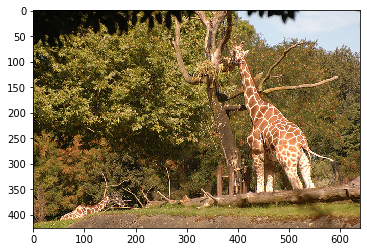

A motorcycle parked in a parking space next to another motorcycle.
An old motorcycle parked beside other motorcycles with a brown leather seat.
Motorcycle parked in the parking lot of asphalt.
A close up view of a motorized bicycle, sitting in a rack. 
The back tire of an old style motorcycle is resting in a metal stand. 


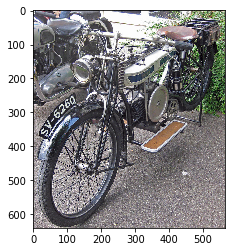

A person doing karate in a field at night
A man standing on a lush green field holding a Frisbee.
A man throwing a frisbee in a dark field.
A man raring back with a frisbee in his hand while on a darkened field.
A man standing outside on the grass at night making body motions.


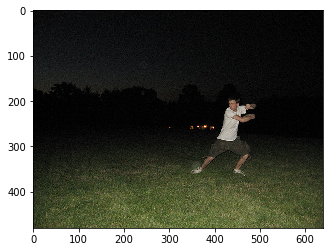

In [22]:
show_image(idx=1, train=True)
show_image(idx=11, train=True)
show_image(idx=111, train=True)

## Pre-Trained Image Model (VGG16)

Vom crea o instanta de VGG16 folosind API-ul de Keras. Modelul a fost deja preantrenat pe setul de date ImageNet. VGG16 contine un segment de straturi convolutionale urmata de staturi fully-connected, folosite pentru clasificarea imaginilor.

`include_top=True` va descarca intreaga retea ce are 528 de MB. Avem nevoie de intreaga retea deoarce vom folosi si o parte din straturile interconectate pentru descrierea imaginilor.



In [23]:
image_model = VGG16(include_top=True, weights='imagenet')

Print a list of all the layers in the VGG16 model.

In [24]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Folosim penultimul layer de clasificare, numit `fc2`. Acesta e un strat dens/complet conecatat.

In [25]:
transfer_layer = image_model.get_layer('fc2')

Il numim "transfer-layer" deoarece va transfera informatiile venite de la reteaua convolutionala.

Cream un nou model ce are aceeasi intrare ca reteaua de mai sus insă iesirea este penultimul strat

In [26]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

Modelul se asteapta ca imaginile sa aiba urmatoarea dimensiune

In [27]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

Pentru fiecare imagine modelul va obtine un vector de 4096 valori

In [28]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

### Procesarea tuturor imaginilor

Vom crea functii ce au rol sa preproceseze imaginile din seturile de date folosind modelul preantrenat si salvand valorile intr-un fisier pentru a putea fi reincarcate rapid.

Obtinem astfel un nou set de date de intrare cu valorile preprocesate. Nu vom schimba toți parametrii modelului VGG16. Avem nevoie de valorile de transfer pentru a instrui modelul de subtitrare a imaginii pentru mai multe epoci, astfel încât economisim mult timp calculând valorile de transfer o dată și salvându-le într-un fișier *.pkl in prealabil.

Aceasta este o funcție de ajutor pentru afisarea progresului.

In [29]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()


Aceasta este funcția pentru procesarea fișierelor date folosind modelul VGG16 și returnarea valorilor de transfer ale acestora.

In [30]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

Procesarea imagnilor de antrenare

In [31]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

Procesarea imagnilor de validare

In [32]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

Procesam toate imaginile din setul de antrenament și le salvam valorile de transfer într-un fișier cache. Acest proces a durat aproximativ 90 de minute pentru o GPU 1060 GTX.

In [33]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Data loaded from cache-file: data/coco/transfer_values_train.pkl
dtype: float16
shape: (118287, 4096)
Wall time: 1.32 s


Procesam toate imaginile din setul de validare și le salvam valorile de transfer într-un fișier cache. Acest proces a durat aproximativ 600 de secunde pentru o GPU 1060 GTX.

In [34]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

NameError: name 'filenames_val' is not defined

## Tokenizer

Neural Networks cannot work directly on text-data. We use a two-step process to convert text into numbers that can be used in a neural network. The first step is to convert text-words into so-called integer-tokens. The second step is to convert integer-tokens into vectors of floating-point numbers using a so-called embedding-layer. See Tutorial #20 for a more detailed explanation.

Before we can start processing the text, we first need to mark the beginning and end of each text-sequence with unique words that most likely aren't present in the data.

In [35]:
mark_start = 'ssss '
mark_end = ' eeee'

This helper-function wraps all text-strings in the above markers. Note that the captions are a list of list, so we need a nested for-loop to process it. This can be done using so-called list-comprehension in Python.

In [36]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

Now process all the captions in the training-set and show an example.

In [37]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

This helper-function converts a list-of-list to a flattened list of captions.

In [38]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

Now use the function to convert all the marked captions from the training set.

In [39]:
captions_train_flat = flatten(captions_train_marked)

Set the maximum number of words in our vocabulary. This means that we will only use e.g. the 10000 most frequent words in the captions from the training-data.

In [40]:
num_words = 10000

We need a few more functions than provided by Keras' Tokenizer-class so we wrap it.

In [41]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

Now create a tokenizer using all the captions in the training-data. Note that we use the flattened list of captions to create the tokenizer because it cannot take a list-of-lists.

In [42]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

Wall time: 8.23 s


Get the integer-token for the start-marker (the word "ssss"). We will need this further below.

In [43]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

Get the integer-token for the end-marker (the word "eeee").

In [44]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

Convert all the captions from the training-set to sequences of integer-tokens. We get a list-of-list as a result.

In [45]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

Wall time: 7.72 s


Example of the integer-tokens for the captions of the first image in the training-set:

In [46]:
tokens_train[0]

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

These are the corresponding text-captions:

In [47]:
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

## Data Generator

Each image in the training-set has at least 5 captions describing the contents of the image. The neural network will be trained with batches of transfer-values for the images and sequences of integer-tokens for the captions. If we were to have matching numpy arrays for the training-set, we would either have to only use a single caption for each image and ignore the rest of this valuable data, or we would have to repeat the image transfer-values for each of the captions, which would waste a lot of memory.

A better solution is to create a custom data-generator for Keras that will create a batch of data with randomly selected transfer-values and token-sequences.

This helper-function returns a list of random token-sequences for the images with the given indices in the training-set.

In [48]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

This generator function creates random batches of training-data for use in training the neural network.

In [49]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

Test the data-generator by creating a batch of data.

### Steps Per Epoch

One epoch is a complete processing of the training-set. We would like to process each image and caption pair only once per epoch. However, because each batch is chosen completely at random in the above batch-generator, it is possible that an image occurs in multiple batches within a single epoch, and it is possible that some images may not occur in any batch at all within a single epoch.

Nevertheless, we still use the concept of an 'epoch' to measure approximately how many iterations of the training-data we have processed. But the data-generator will generate batches for eternity, so we need to manually calculate the approximate number of batches required per epoch.

This is the number of captions for each image in the training-set.

In [50]:
num_captions_train = [len(captions) for captions in captions_train]

This is the total number of captions in the training-set.

In [51]:
total_num_captions_train = np.sum(num_captions_train)

## Create the Recurrent Neural Network

We will now create the Recurrent Neural Network (RNN) that will be trained to map the vectors with transfer-values from the image-recognition model into sequences of integer-tokens that can be converted into text. We call this neural network for the 'decoder' as it is almost identical to the decoder when doing Machine Translation in Tutorial #21.

Note that we are using the functional model from Keras to build this neural network, because it allows more flexibility in how the neural network can be connected, in case you want to experiment and connect the image-model directly to the decoder (see the exercises). This means we have split the network construction into two parts: (1) Creation of all the layers that are not yet connected, and (2) a function that connects all these layers.

The decoder consists of 3 GRU layers whose internal state-sizes are:

In [52]:
state_size = 512

The embedding-layer converts integer-tokens into vectors of this length:

In [53]:
embedding_size = 128

This inputs transfer-values to the decoder:

In [54]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

We want to use the transfer-values to initialize the internal states of the GRU units. This informs the GRU units of the contents of the images. The transfer-values are vectors of length 4096 but the size of the internal states of the GRU units are only 512, so we use a fully-connected layer to map the vectors from 4096 to 512 elements.

Note that we use a `tanh` activation function to limit the output of the mapping between -1 and 1, otherwise this does not seem to work.

In [55]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

This is the input for token-sequences to the decoder. Using `None` in the shape means that the token-sequences can have arbitrary lengths.

In [56]:
decoder_input = Input(shape=(None, ), name='decoder_input')

This is the embedding-layer which converts sequences of integer-tokens to sequences of vectors.

In [57]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

This creates the 3 GRU layers of the decoder. Note that they all return sequences because we ultimately want to output a sequence of integer-tokens that can be converted into a text-sequence.


In [58]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

The GRU layers output a tensor with shape `[batch_size, sequence_length, state_size]`, where each "word" is encoded as a vector of length `state_size`. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

One way of doing this is to convert the GRU output to a one-hot encoded array. It works but it is extremely wasteful, because for a vocabulary of e.g. 10000 words we need a vector with 10000 elements, so we can select the index of the highest element to be the integer-token.

In [59]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output')

### Connect and Create the Training Model

The decoder is built using the functional API of Keras, which allows more flexibility in connecting the layers e.g. to have multiple inputs. This is useful e.g. if you want to connect the image-model directly with the decoder instead of using pre-calculated transfer-values.

This function connects all the layers of the decoder to some input of transfer-values.

In [60]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

Connect and create the model used for training. This takes as input transfer-values and sequences of integer-tokens and outputs sequences of one-hot encoded arrays that can be converted into integer-tokens.

In [61]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

### Compile the Model

The output of the decoder is a sequence of one-hot encoded arrays. In order to train the decoder we need to supply the one-hot encoded arrays that we desire to see on the decoder's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

However, our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has 10000 elements so it would be extremely wasteful to convert the entire data-set to one-hot encoded arrays. We could do this conversion from integers to one-hot arrays in the `batch_generator()` above.

A better way is to use a so-called sparse cross-entropy loss-function, which does the conversion internally from integers to one-hot encoded arrays.

We have used the Adam optimizer in many of the previous tutorials, but it seems to diverge in some of these experiments with Recurrent Neural Networks. RMSprop seems to work much better for these.

In [62]:
decoder_model.compile(optimizer=tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False),
                      loss='sparse_categorical_crossentropy')

### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [63]:
path_checkpoint = 'captionThisModel.h5'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

This is the callback for writing the TensorBoard log during training.

In [64]:
callback_tensorboard = TensorBoard(log_dir='./captionThis_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [65]:
callbacks = [callback_checkpoint, callback_tensorboard]

### Load Checkpoint

You can reload the last saved checkpoint so you don't have to train the model every time you want to use it.

In [66]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

### Train the Model

Now we will train the decoder so it can map transfer-values from the image-model to sequences of integer-tokens for the captions of the images.

One epoch of training took about 2 hours on a GTX 1060 GPU, 6GB. 

Note that if we didn't use pre-computed transfer-values then each epoch would take maybe 40 minutes to run, because all the images would have to be processed by the VGG16 model as well.

In [67]:
batch_size = 1000
generator = batch_generator(batch_size=batch_size)
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

591

In [141]:
%%time
decoder_model.fit(x=generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=10,
                  callbacks=callbacks)

Epoch 1/10
295/295 [==============================] - ETA: 0s - loss: 0.6806 
Epoch 00001: saving model to captionThisModel.h5
295/295 [==============================] - 17519s 59s/step - loss: 0.6806
Epoch 2/10
295/295 [==============================] - ETA: 0s - loss: 0.6770  
Epoch 00002: saving model to captionThisModel.h5
295/295 [==============================] - 18075s 61s/step - loss: 0.6770
Epoch 3/10
295/295 [==============================] - ETA: 0s - loss: 0.6564  
Epoch 00003: saving model to captionThisModel.h5
295/295 [==============================] - 17881s 61s/step - loss: 0.6564
Epoch 4/10
295/295 [==============================] - ETA: 0s - loss: 0.6512  
Epoch 00004: saving model to captionThisModel.h5
295/295 [==============================] - 19080s 65s/step - loss: 0.6512
Epoch 5/10
295/295 [==============================] - ETA: 0s - loss: 0.6546  
Epoch 00005: saving model to captionThisModel.h5
295/295 [==============================] - 18077s 61s/step - loss

## Generate Captions

This function loads an image and generates a caption using the model we have trained.

In [78]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input
    
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        
        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

### Examples

Try this with a picture of 2 birds.

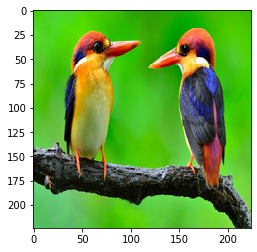

Predicted caption:
 a bird is sitting on a branch of a tree eeee



In [79]:
generate_caption("test/birds.jpg")

Try this with a picture of an athlete.

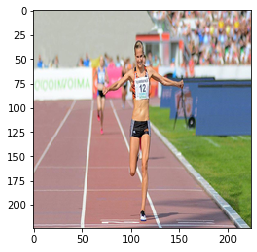

Predicted caption:
 a baseball player is up to bat at a game eeee



In [60]:
generate_caption("test/athlete.jpg")

Try this with a picture of a bear

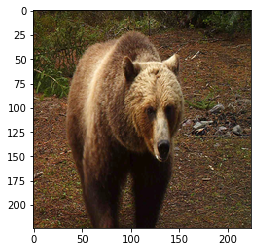

Predicted caption:
 a bear is standing on a rocky surface eeee



In [61]:
generate_caption("test/bear.jpg")

Try this with a picture of a beach

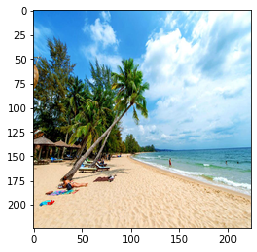

Predicted caption:
 a person on a beach flying a kite eeee



In [62]:
generate_caption("test/beach.jpg") 

Try this with a picture of a car

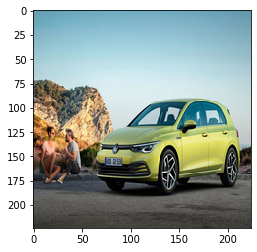

Predicted caption:
 a car parked on the side of a road with a truck behind it eeee



In [63]:
generate_caption("test/golf.jpg") 

Try this with a picture of a man.

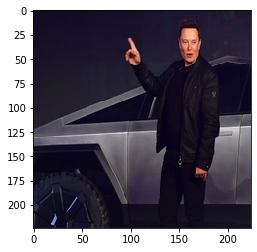

Predicted caption:
 a man is standing in front of a mirror eeee



In [64]:
generate_caption("test/musk.jpeg") 

Try this with a picture of a woman.

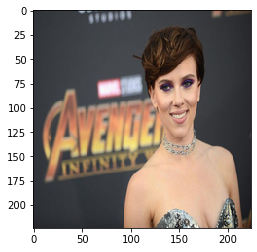

Predicted caption:
 a man in a suit and tie is looking at his cell phone eeee



In [65]:
generate_caption("test/scarlet.jpg") 

Try this with a picture of a deer.

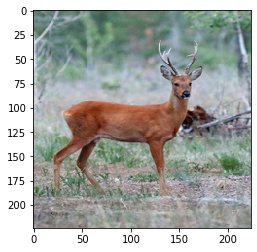

Predicted caption:
 a giraffe standing in a field with a tree in the background eeee



In [66]:
generate_caption("test/deer.jpg") 

Helper-function for loading an image from the COCO data-set and printing the true captions as well as the predicted caption.

In [72]:
def generate_caption_coco(idx, train=False):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    generate_caption(image_path=path)

    # Print the true captions from the data-set.
    print("True captions:")
    for caption in captions:
        print(caption)

Try this on a picture from the training-set that the model has been trained on. In some cases the generated caption is actually better than the human-generated captions.

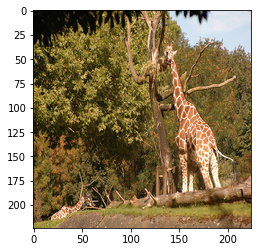

Predicted caption:
 a giraffe standing in a field of grass and trees eeee

True captions:
A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


In [73]:
generate_caption_coco(idx=1, train=True)

Here is another picture of giraffes from the training-set, so this image was also used during training of the model. But the model can't produce an accurate caption. Perhaps it needs more training, or perhaps another architecture for the Recurrent Neural Network?

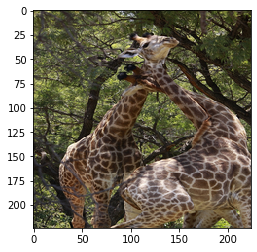

Predicted caption:
 a giraffe standing in a field of grass and rocks eeee

True captions:
A couple of giraffe snuggling each other in a forest.
A couple of giraffe standing next to some trees.
Two Zebras seem to be embracing in the wild. 
Two giraffes hang out near trees and nuzzle up to each other.
The two giraffes appear to be hugging each other.


In [74]:
generate_caption_coco(idx=10, train=True)

Here is a picture from the validation-set which was not used during training of the model. Sometimes the model can produce good captions for images it hasn't seen during training and sometimes it can't. Can you make a better model?

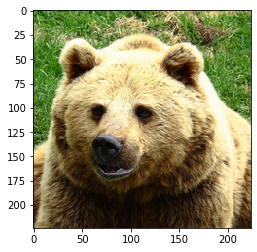

Predicted caption:
 a dog is laying on the ground with a frisbee in its mouth eeee

True captions:
A big burly grizzly bear is show with grass in the background.
The large brown bear has a black nose.
Closeup of a brown bear sitting in a grassy area.
A large bear that is sitting on grass. 
A close up picture of a brown bear's face.


In [75]:
generate_caption_coco(idx=1, train=False)

Urmeaza sa converitm modelul in tensorflowLite

In [91]:
decoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
transfer_values_input (InputLay [(None, 4096)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 128)    1280000     decoder_input[0][0]              
__________________________________________________________________________________________________
decoder_transfer_map (Dense)    (None, 512)          2097664     transfer_values_input[0][0]      
____________________________________________________________________________________________

In [67]:
decoder_model.save(r'C:\Users\George\Desktop\Dizertatie\Python\Caption Model\finalModel')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\George\Desktop\Dizertatie\Python\Caption Model\finalModel\assets


In [3]:
newModel=tf.keras.models.load_model('finalModel')
newModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
transfer_values_input (InputLay [(None, 4096)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 128)    1280000     decoder_input[0][0]              
__________________________________________________________________________________________________
decoder_transfer_map (Dense)    (None, 512)          2097664     transfer_values_input[0][0]      
____________________________________________________________________________________________

## Conclusion

This tutorial showed how to generate captions for images. We used a pre-trained image-model (VGG16) to generate a "thought-vector" of what the image contains, and then we trained a Recurrent Neural Network to map this "thought-vector" to a sequence of words.

This works reasonably well, although it is easy to find examples both in the training- and validation-sets where the captions are incorrect.

It is also important to understand that this model doesn't have a human-like understanding of what the images contain. If it sees an image of a giraffe and correctly produces a caption stating that, it doesn't mean that the model has a deep understanding of what a giraffe is; the model doesn't know that it's a tall animal that lives in Africa and Zoos.

The model is merely a clever way of mapping pixels in an image to a vector of floating-point numbers that summarize the contents of the image, and then map these numbers to a sequence of integers-tokens representing words. So the model is basically just a very advanced function approximator rather than human-like intelligence.